In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
import pandas as pd
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
plt.style.use('ggplot')
%matplotlib inline

In [105]:
import cifar10_input
sess = tf.InteractiveSession()
for i in range(100):
    print (i)
    images, labels = sess.run(cifar10_input.distorted_inputs(batch_size=100))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


E0501 11:10:48.227800 140737270424512 ultratb.py:149] Internal Python error in the inspect module.
Below is the traceback from this internal error.

E0501 11:10:48.265864 140737270424512 ultratb.py:149] Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/senqicao/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1334, in _do_call
    return fn(*args)
  File "/Users/senqicao/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1319, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "/Users/senqicao/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1407, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.ResourceExhaustedError: /Users/senqicao/tensorflow_datasets/cifar10/1.0.2/cifar10-train.tfrecord-00003-of-00010; Too many open files
	 [[{{node IteratorGetNext_20}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/sen

TypeError: can only concatenate str (not "list") to str

W0430 16:17:17.331994 140737270424512 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


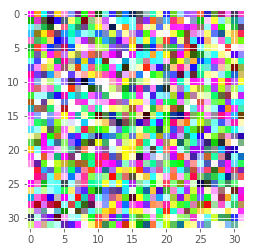

In [4]:
im = np.random.normal(0,1,[32*32*3])
im = np.reshape(np.abs(im) ,[32,32,3])
plt.imshow(im)
plt.show()
safe_images = np.reshape(np.random.normal(0,1,[32*32*3*9200]),[9200,32,32,3])

In [8]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = np.reshape(y_train,[50000,])
y_test = np.reshape(y_test,[10000,])
nb_classes = 10
targets = y_train.reshape(-1)
y_train = np.eye(nb_classes)[targets]
targets = y_test.reshape(-1)
y_test = np.eye(nb_classes)[targets]

M = 128
D=4*4*512
h1=1024
D2=10

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def pad3D(c_x, padlen=1):
    batch,m,n,r = c_x.shape
    c_y = np.zeros((batch,m+2*padlen, n+2*padlen, r),dtype=c_x.dtype)
    c_y[:, padlen:-padlen, padlen:-padlen,:] = c_x
    return c_y

def randomCrop(img, width, height):
    assert img.shape[1] >= height
    assert img.shape[2] >= width
    x = np.random.randint(0, img.shape[2] - width)
    y = np.random.randint(0, img.shape[1] - height)
    img = img[:,y:y+height, x:x+width,:]
    return img

def stand(im):
    im = im.astype(np.float64,copy=False)
    mean = np.mean(im)
    std = np.std(im)
    std1 = max(std,1./np.sqrt(np.array(im.size,dtype = np.float64)))
    im = (im-mean)/std1
    return im

def preprocess(x_batch):
    x_batch = pad3D(x_batch, padlen=4)
    x_batch = randomCrop(x_batch, 32, 32)
    x_batch = x_batch[:,:,::-1,...]
    x_batch = stand(x_batch)
    return x_batch

tf.reset_default_graph()
# variables
with tf.device('/gpu:0'):
    X = tf.placeholder(tf.float32, shape = [None, 32, 32, 3])
    Y = tf.placeholder(tf.float32, [None,10])
    b = tf.placeholder(tf.bool,shape=(),name='b')
    learning_rate = tf.placeholder(tf.float32,shape=(),name='learning_rate')
    probability = tf.placeholder(tf.float32,shape=(),name='probability')
    #global_step = tf.Variable(0, trainable=False)

    w_conv1 = tf.get_variable('w_conv1', [3,3,3,128], initializer = tf.contrib.layers.xavier_initializer())
    w_conv2 = tf.get_variable('w_conv2', [3,3,128,128], initializer = tf.contrib.layers.xavier_initializer())
    w_conv3 = tf.get_variable('w_conv3', [3,3,128,256], initializer = tf.contrib.layers.xavier_initializer())
    w_conv4 = tf.get_variable('w_conv4', [3,3,256,256], initializer = tf.contrib.layers.xavier_initializer())
    w_conv5 = tf.get_variable('w_conv5', [3,3,256,512], initializer = tf.contrib.layers.xavier_initializer())
    w_conv6 = tf.get_variable('w_conv6', [3,3,512,512], initializer = tf.contrib.layers.xavier_initializer())

    w0 = tf.get_variable('w_fc1', [4*4*512, 1024], initializer = tf.contrib.layers.xavier_initializer())
    b0 = tf.get_variable('b_fc1', [1,1024], initializer = tf.contrib.layers.xavier_initializer())
    w1 = tf.get_variable('w_fc2', [1024, 1024], initializer = tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable('b_fc2', [1,1024], initializer = tf.contrib.layers.xavier_initializer())
    w2 = tf.get_variable('w_fc3', [1024, 10], initializer = tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable('b_fc3', [1,10], initializer = tf.contrib.layers.xavier_initializer())

    # network
    con1 = tf.nn.conv2d(X, w_conv1, strides=[1, 1, 1, 1], padding='SAME')
    #h_conv1 = tf.nn.relu(tf.layers.batch_normalization(con1, training=b))
    h_conv1 = tf.layers.batch_normalization(tf.nn.relu(con1), training=b)

    con2 = tf.nn.conv2d(h_conv1, w_conv2, strides=[1, 1, 1, 1], padding='SAME')
    #h_conv2 = tf.nn.relu(tf.layers.batch_normalization(con2, training=b))
    h_conv2 = tf.layers.batch_normalization(tf.nn.relu(con2), training=b)
    h_pool2 = max_pool_2x2(h_conv2)

    con3 = tf.nn.conv2d(h_pool2, w_conv3, strides=[1, 1, 1, 1], padding='SAME')
    #h_conv3 = tf.nn.relu(tf.layers.batch_normalization(con3, training=b))
    h_conv3 = tf.layers.batch_normalization(tf.nn.relu(con3), training=b)

    con4 = tf.nn.conv2d(h_conv3, w_conv4, strides=[1, 1, 1, 1], padding='SAME')
    #h_conv4 = tf.nn.relu(tf.layers.batch_normalization(con4, training=b))
    h_conv4 = tf.layers.batch_normalization(tf.nn.relu(con4), training=b)
    h_pool4 = max_pool_2x2(h_conv4)

    con5 = tf.nn.conv2d(h_pool4, w_conv5, strides=[1, 1, 1, 1], padding='SAME')
    #h_conv5 = tf.nn.relu(tf.layers.batch_normalization(con5, training=b))
    h_conv5 = tf.layers.batch_normalization(tf.nn.relu(con5), training=b)

    con6 = tf.nn.conv2d(h_conv5, w_conv6, strides=[1, 1, 1, 1], padding='SAME')
    #h_conv6 = tf.nn.relu(tf.layers.batch_normalization(con6, training=b))
    h_conv6 = tf.layers.batch_normalization(tf.nn.relu(con6), training=b)
    h_pool6 = max_pool_2x2(h_conv6)

    h_pool_flat = tf.layers.flatten(h_pool6)

    h = tf.nn.relu(tf.matmul(h_pool_flat, w0) + b0)
    #h = tf.nn.relu(tf.matmul(h_pool_flat, w0))
    #h = tf.nn.relu(tf.layers.batch_normalization(h, training=b))
    #h = tf.nn.dropout(h, keep_prob = probability)
    h = tf.matmul(h, w1) + b1
    logits = tf.matmul(h, w2) + b2

    output = tf.nn.softmax(logits)#batch*10

    #evaluation
    probs = tf.reduce_sum(output*Y,1)#batch*1
    p=tf.reduce_mean(probs,0)#积分
    #cross_ent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits,labels = tf.cast(Y, tf.int64)))
    cross_ent = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels=Y))
    regularization = 1e-4*(tf.reduce_sum(tf.square(w0))+tf.reduce_sum(tf.square(b0))
                           +tf.reduce_sum(tf.square(w1))+tf.reduce_sum(tf.square(b1))
                           +tf.reduce_sum(tf.square(w2))+tf.reduce_sum(tf.square(b2))
                           +tf.reduce_sum(tf.square(w_conv1))+tf.reduce_sum(tf.square(w_conv2))
                           +tf.reduce_sum(tf.square(w_conv3))+tf.reduce_sum(tf.square(w_conv4))
                           +tf.reduce_sum(tf.square(w_conv5))+tf.reduce_sum(tf.square(w_conv6)))
    
    loss = cross_ent + regularization
    max_p = tf.reduce_max(output,1)
    ent = tf.reduce_sum(-tf.log(output+1e-11)*output,1)

    correct_pred = tf.equal(tf.argmax(output,1), tf.argmax(Y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # training
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

saver = tf.train.Saver(max_to_keep = 5)
config = tf.ConfigProto(allow_soft_placement = True)
with tf.Session(config = config) as sess:
    start_time = time.time()
    sess.run(tf.global_variables_initializer())
    model_id=0
    #save_path = saver.restore(sess, "./baseline_point_estimation/classification_mnist60/model.ckpt")
    for i in range(190000):
        #print("time",i,time.time() - start_time, file=open("prints.txt", "a")) 
        #print("time",i,time.time() - start_time) 
        #start_time1 = time.time()
        seed = np.random.randint(0,50000,100)
        x_batch = x_train[seed]
        y_batch = y_train[seed]
        x_batch = preprocess(x_batch)
        #print('preprocessing:',time.time() - start_time1)

        if i%100==0:
            print("time",i,time.time() - start_time) 
            print("time",i,time.time() - start_time, file=open("prints.txt", "a")) 
            maxp_OOD = []
            ent_OOD = []
            test_accuracy = []
            maxp_in = []
            ent_in = [] 

            for j in range(0,100):
                #start_time = time.time()
                imgs_in = x_test[j*100:(j+1)*100]
                labels_in = y_test[j*100:(j+1)*100]
                imgs_in = stand(imgs_in)
                #print('preprocessing:',time.time() - start_time)

                acc = sess.run(accuracy,{X:np.reshape(imgs_in,[100,32,32,3]),Y:labels_in,b:False,probability:1})
                #maxp_in1 = sess.run(max_p,{X:np.reshape(imgs_in,[100,32,32,3]),b:False})
                #ent_in1 = sess.run(ent,{X:np.reshape(imgs_in,[100,32,32,3]),b:False})
                test_accuracy.append(acc)
                #maxp_in.extend(maxp_in1)
                #ent_in.extend(ent_in1)

            #x_test = stand(x_test)
            #acc = sess.run(accuracy,{X:np.reshape(x_test[:10000],[10000,32,32,3]),Y:y_test[:10000],b:False,probability:1})
            #test_accuracy = np.array(test_accuracy)
            #test_accuracy = np.mean(np.array(test_accuracy))

            #maxp_in = np.array(maxp_in)
            #ent_in = np.array(ent_in)
            test_error = np.mean(np.array(test_accuracy))
            print("test:",test_error)
            print("test:",test_error, file=open("prints.txt", "a")) 
            '''
            safe_images = np.reshape(np.random.normal(0,1,[32*32*3*9200]),[9200,32,32,3])
            for k in range(0,92):
                imgs_OOD = safe_images[k*100:(k+1)*100]
                maxp_OOD1 = sess.run(max_p,{X:np.reshape(imgs_OOD,[100,32,32,3]),b:False})
                ent_OOD1 = sess.run(ent,{X:np.reshape(imgs_OOD,[100,32,32,3]),b:False})
                maxp_OOD.extend(maxp_OOD1)
                ent_OOD.extend(ent_OOD1)
            maxp_OOD = np.array(maxp_OOD)
            ent_OOD = np.array(ent_OOD)


            #validation_error = sess.run(accuracy, {X:np.reshape(validation_x,[1000,28,28,1]), Y:validation_y,b:False})
            test_error = np.mean(np.array(test_accuracy))
            print ("time:",i, time.time() - start_time, "test accuracy", test_error)
            print("maxp_OOD:",np.mean(maxp_OOD>0.99),np.mean(maxp_OOD),np.std(maxp_OOD))
            print("maxp_inD:",np.mean(maxp_in>0.99),np.mean(maxp_in),np.std(maxp_in))
            print("ent_OOD:",np.mean(ent_OOD),np.std(ent_OOD), "ent_in:", np.mean(ent_in),np.std(ent_in))

            safe, risky  = -np.reshape(maxp_in,[10000,1]), -np.reshape(maxp_OOD,[9200,1])
            labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
            labels[safe.shape[0]:] += 1
            examples = np.squeeze(np.vstack((safe, risky)))
            print('AUPR_p:', round(100*average_precision_score(labels, examples), 2))
            print('AUROC_p:', round(100*roc_auc_score(labels, examples), 2))

            safe, risky = np.reshape(ent_in,[10000,1]), np.reshape(ent_OOD,[9200,1])
            labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
            labels[safe.shape[0]:] += 1
            examples = np.squeeze(np.vstack((safe, risky)))
            print('AUPR_entropy:', round(100*average_precision_score(labels, examples), 2))
            print('AUROC_entropy:', round(100*roc_auc_score(labels, examples), 2))
            print("############################################")
            '''
        '''
        if i < 5000:
            a = 0.001
        elif i < 10000:
            a = 0.0005
        elif i < 30000:
            a = 0.0001
        elif i < 50000:
            a = 0.00005
        elif i < 80000:
            a = 0.00001
        else:
            a = 0.000005
        '''
        #assign_op = global_step.assign(i)
        #sess.run(assign_op)
        
        epoch = i*128/50000
        a = 0.001 * (0.5 ** (epoch // 20))

        sess.run(train_step,{X: x_batch, Y: y_batch,learning_rate:a, b:True,probability:0.7})

        if i%500==0:
            save_path = saver.save(sess, "./cifar10_point_estimation/classification_mnist%s/model.ckpt" % model_id)
            model_id+=1

time 0 0.8550169467926025
test: 0.1
time 100 761.6637651920319
test: 0.1191


KeyboardInterrupt: 

In [284]:
x_batch = x_train[11]

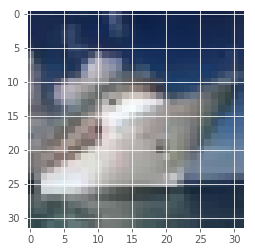

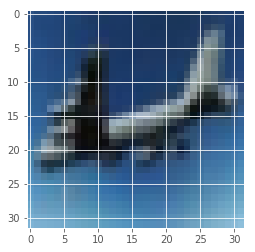

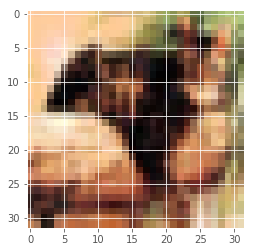

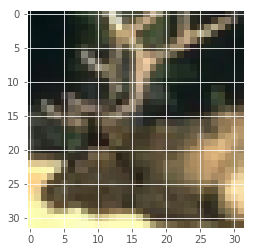

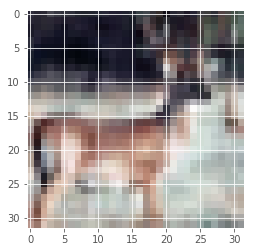

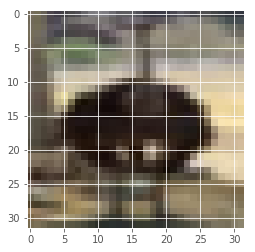

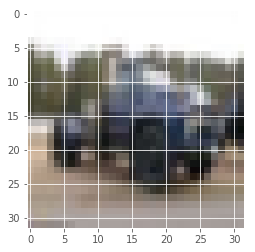

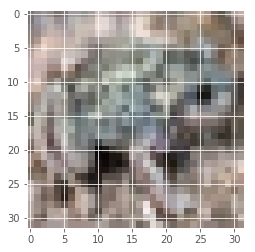

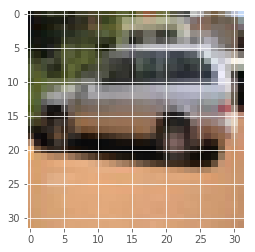

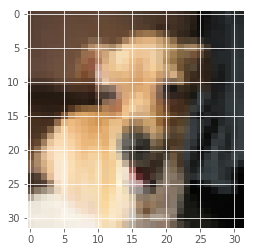

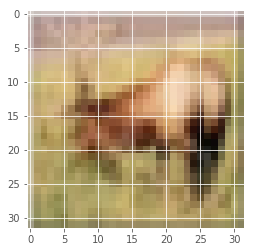

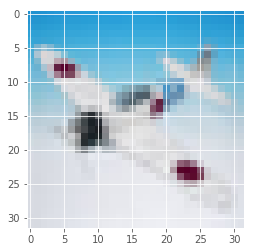

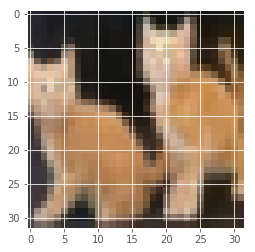

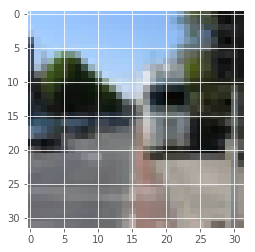

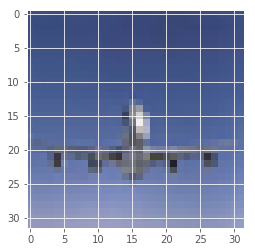

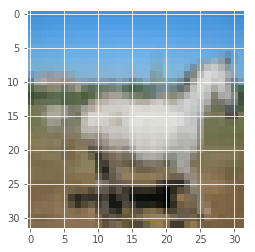

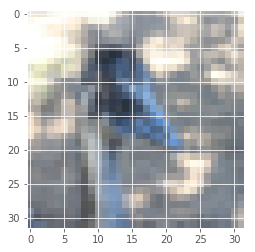

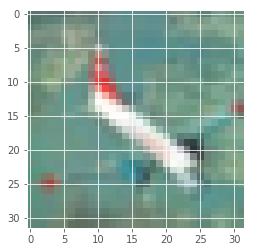

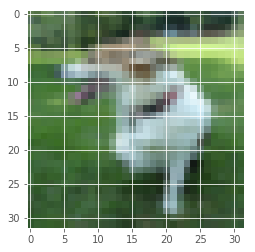

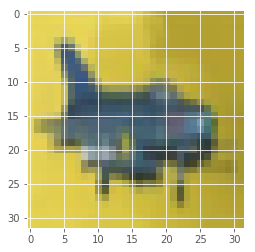

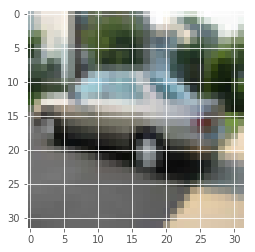

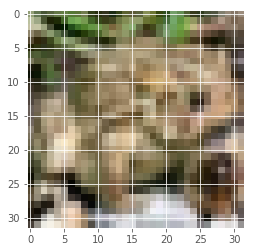

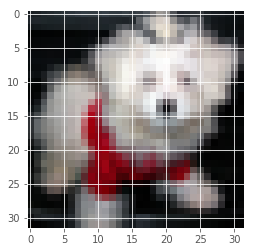

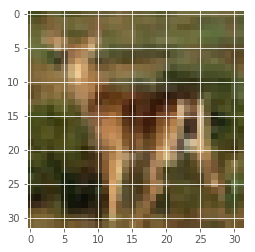

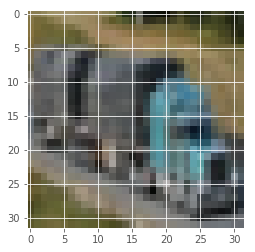

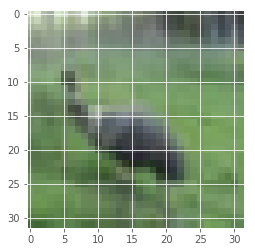

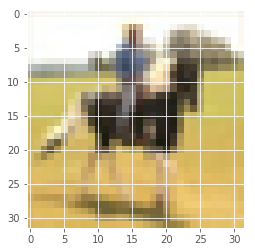

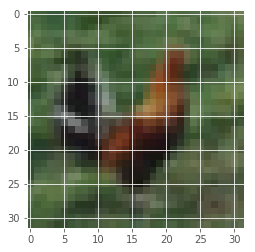

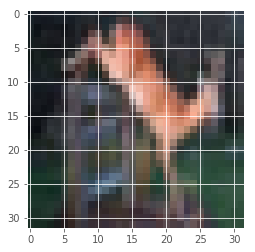

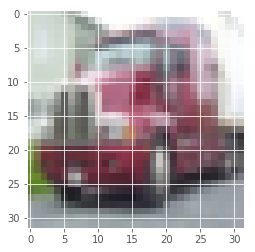

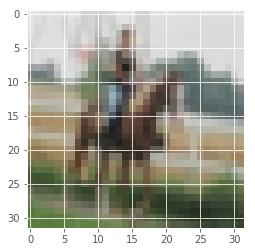

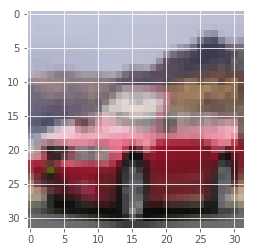

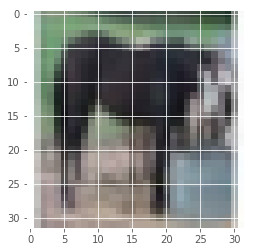

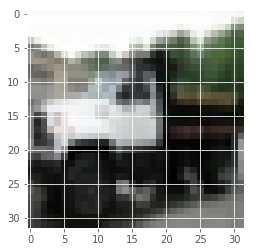

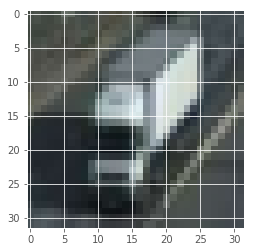

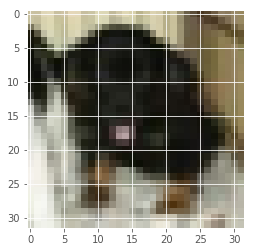

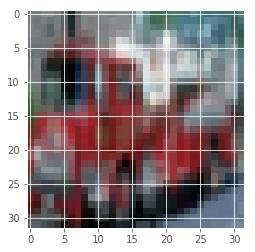

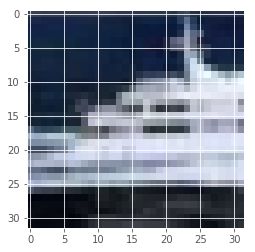

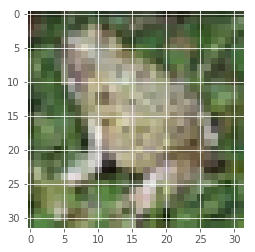

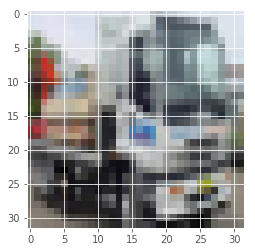

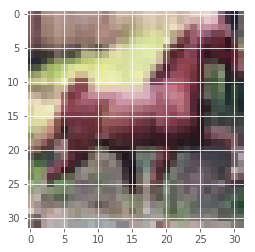

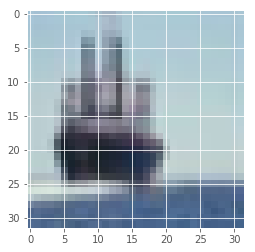

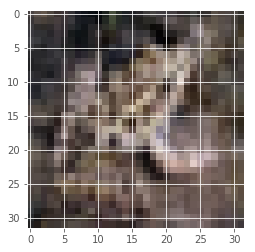

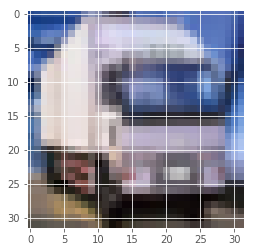

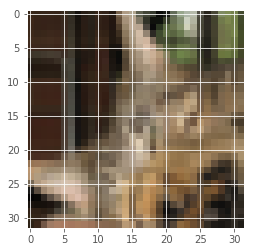

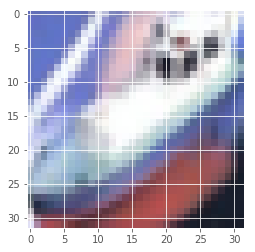

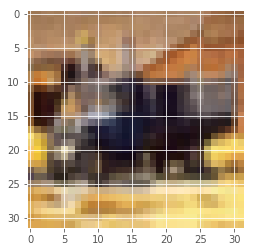

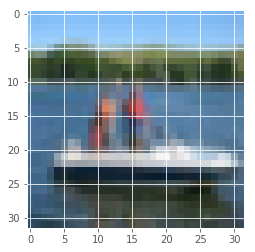

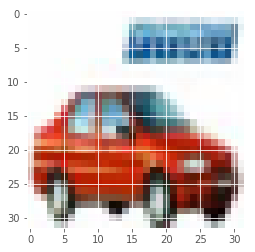

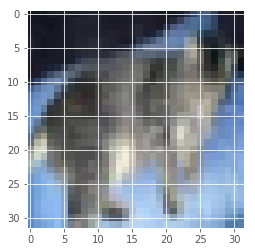

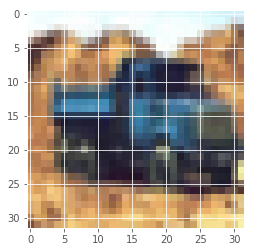

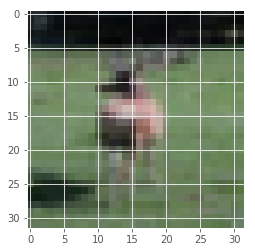

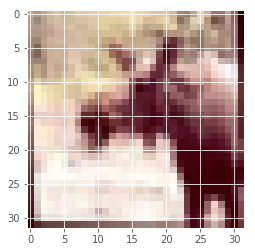

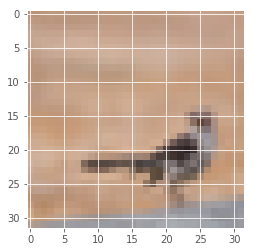

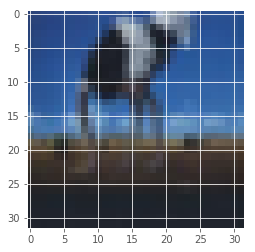

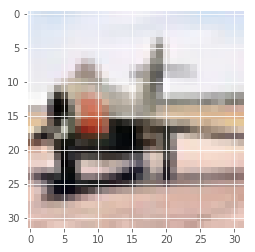

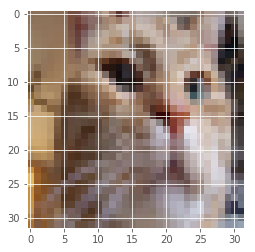

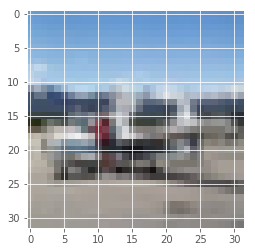

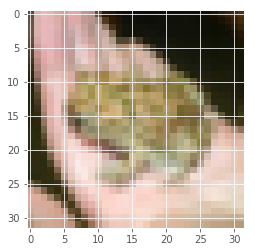

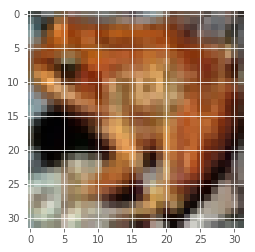

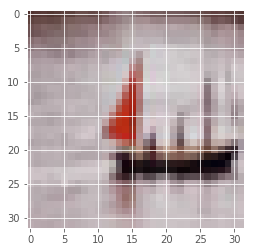

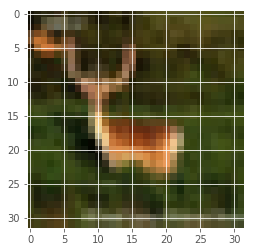

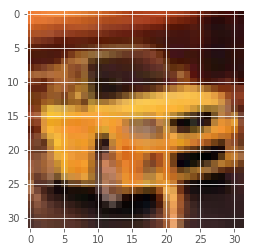

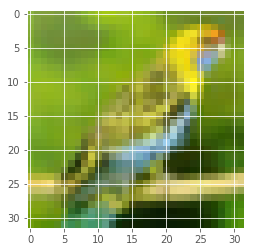

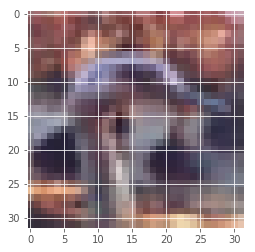

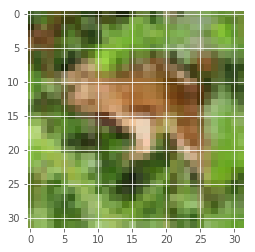

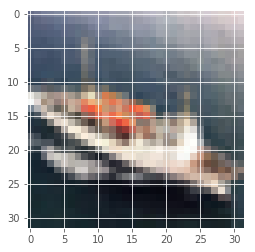

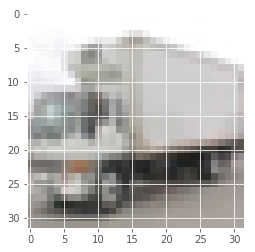

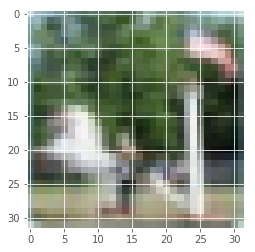

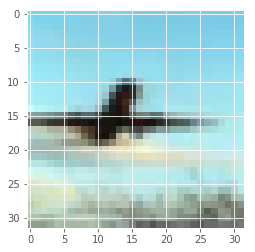

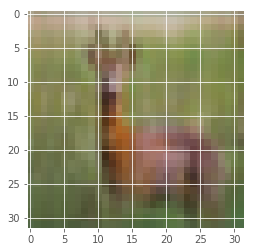

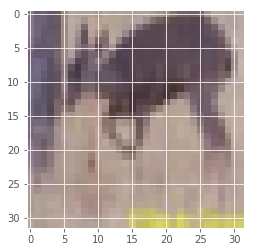

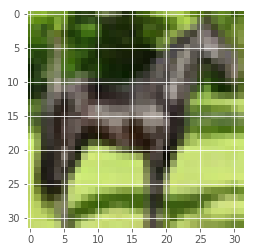

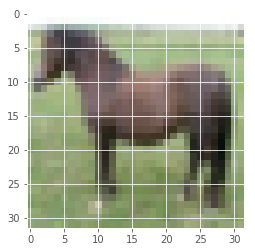

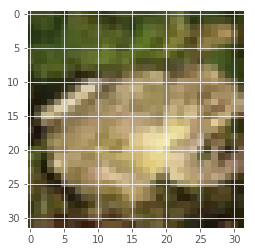

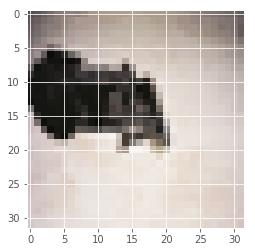

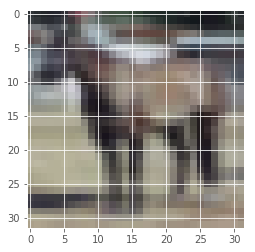

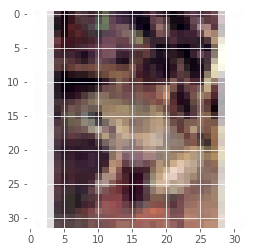

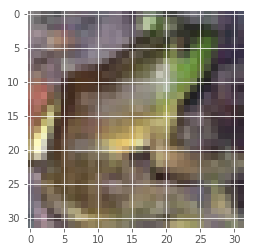

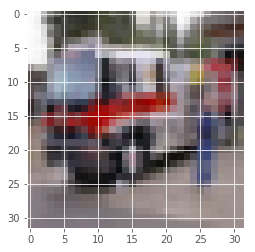

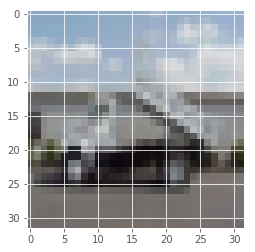

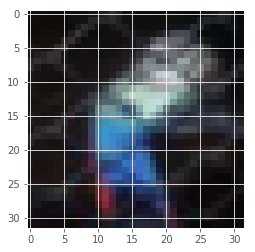

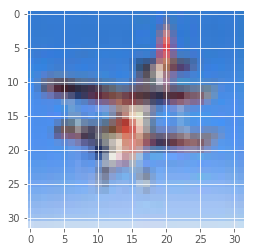

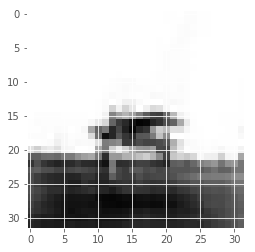

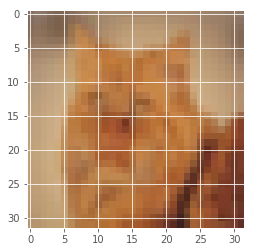

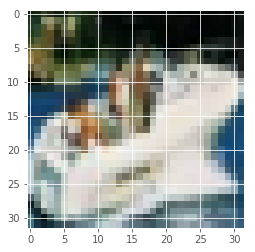

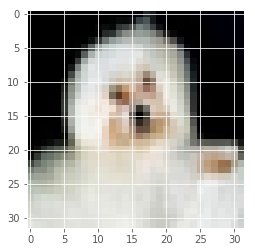

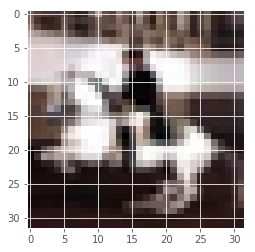

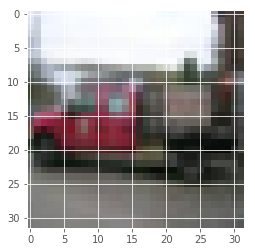

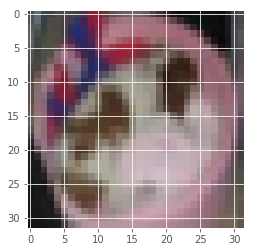

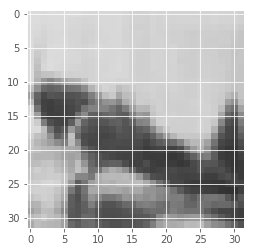

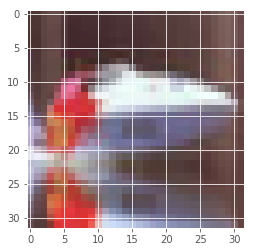

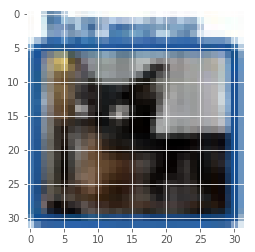

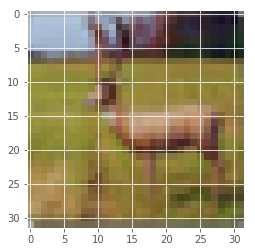

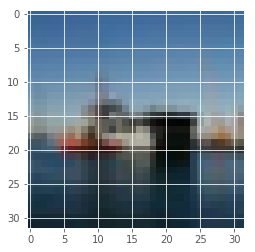

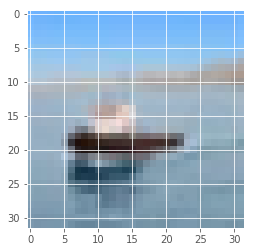

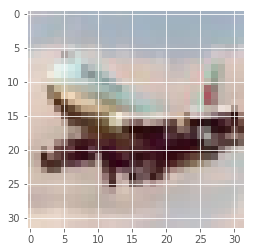

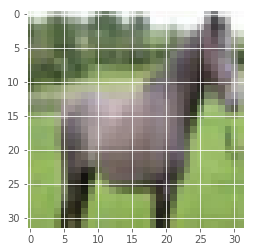

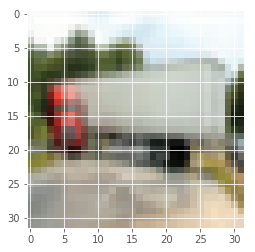

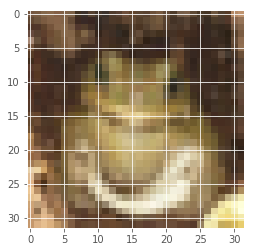

In [297]:
for im in x_batch:
        plt.imshow(im)
        plt.show()

In [286]:
x_batch = preprocess(x_batch)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


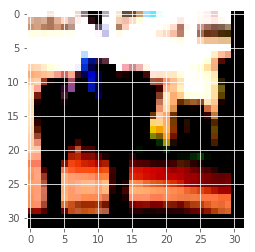

In [287]:
plt.imshow(x_batch)
plt.show()

In [85]:
x_batch.shape

(36, 36, 7)

In [299]:
199*500

99500

In [77]:
x_batch.shape

(100, 32, 32, 3)

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

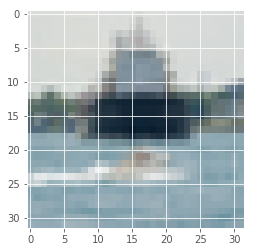

In [10]:
seed = np.random.randint(0,50000,100)
x_batch = x_train[seed]
x_batch = x_batch
plt.imshow(x_batch[1])
plt.show()

In [20]:
sess = tf.InteractiveSession()

/Users/senqicao/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [21]:
x_batch = sess.run(tf.cast(x_batch, tf.float32))

In [30]:
x_batch.shape

(100, 32, 32, 3)

In [29]:
x_batch = sess.run(tf.image.per_image_standardization(x_batch))

In [26]:
x_batch = sess.run(tf.cast(x_batch, tf.float32))
#x_batch = sess.run(tf.random_crop(x_batch, [32, 32, 3]))
x_batch = sess.run(tf.image.random_flip_left_right(x_batch))
#x_batch = sess.run(tf.image.random_brightness(x_batch, max_delta=0.5))
#x_batch = sess.run(tf.image.random_contrast(x_batch, lower=0.2, upper=1.8))
x_batch = sess.run(tf.image.per_image_standardization(x_batch))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


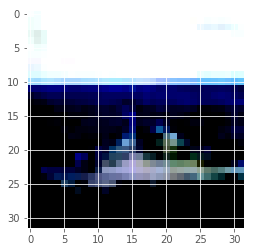

In [27]:
#x_batch = sess.run(tf.image.random_contrast(x_batch, lower=0.2, upper=1.8))
plt.imshow(x_batch[1])
plt.show()

In [259]:
y_train

array([6, 9, 9, ..., 9, 1, 1], dtype=uint8)

In [262]:
nb_classes = 10
targets = y_train.reshape(-1)
y_train = np.eye(nb_classes)[targets]
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [255]:
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops
from tensorflow.python.eager import context

def cyclic_learning_rate(global_step,
                         learning_rate=0.00001,
                         max_lr=0.005,
                         step_size=3000.,
                         gamma=0.997,
                         mode='triangular',
                         name=None):
  if global_step is None:
    raise ValueError("global_step is required for cyclic_learning_rate.")
  with ops.name_scope(name, "CyclicLearningRate",
                      [learning_rate, global_step]) as name:
    learning_rate = ops.convert_to_tensor(learning_rate, name="learning_rate")
    dtype = learning_rate.dtype
    global_step = math_ops.cast(global_step, dtype)
    step_size = math_ops.cast(step_size, dtype)
    def cyclic_lr():
      """Helper to recompute learning rate; most helpful in eager-mode."""
      # computing: cycle = floor( 1 + global_step / ( 2 * step_size ) )
      double_step = math_ops.multiply(2., step_size)
      global_div_double_step = math_ops.divide(global_step, double_step)
      cycle = math_ops.floor(math_ops.add(1., global_div_double_step))
      # computing: x = abs( global_step / step_size – 2 * cycle + 1 )
      double_cycle = math_ops.multiply(2., cycle)
      global_div_step = math_ops.divide(global_step, step_size)
      tmp = math_ops.subtract(global_div_step, double_cycle)
      x = math_ops.abs(math_ops.add(1., tmp))
      # computing: clr = learning_rate + ( max_lr – learning_rate ) * max( 0, 1 - x )
      a1 = math_ops.maximum(0., math_ops.subtract(1., x))
      a2 = math_ops.subtract(max_lr, learning_rate)
      clr = math_ops.multiply(a1, a2)
      if mode == 'triangular2':
        clr = math_ops.divide(clr, math_ops.cast(math_ops.pow(2, math_ops.cast(
            cycle-1, tf.int32)), tf.float32))
      if mode == 'exp_range':
        clr = math_ops.multiply(math_ops.pow(gamma, global_step), clr)
      return math_ops.add(clr, learning_rate, name=name)
    if not context.executing_eagerly():
      cyclic_lr = cyclic_lr()
    return cyclic_lr

## vgg16

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = np.reshape(y_train,[50000,])
y_test = np.reshape(y_test,[10000,])
nb_classes = 10
targets = y_train.reshape(-1)
y_train = np.eye(nb_classes)[targets]
targets = y_test.reshape(-1)
y_test = np.eye(nb_classes)[targets]

M = 128
D=4*4*512
h1=1024
D2=10

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def pad3D(c_x, padlen=1):
    batch,m,n,r = c_x.shape
    c_y = np.zeros((batch,m+2*padlen, n+2*padlen, r),dtype=c_x.dtype)
    c_y[:, padlen:-padlen, padlen:-padlen,:] = c_x
    return c_y

def randomCrop(img, width, height):
    assert img.shape[1] >= height
    assert img.shape[2] >= width
    x = np.random.randint(0, img.shape[2] - width)
    y = np.random.randint(0, img.shape[1] - height)
    img = img[:,y:y+height, x:x+width,:]
    return img

def stand(im):
    im = im.astype(np.float64,copy=False)
    mean = np.mean(im)
    std = np.std(im)
    std1 = max(std,1./np.sqrt(np.array(im.size,dtype = np.float64)))
    im = (im-mean)/std1
    return im

def preprocess(x_batch):
    x_batch = pad3D(x_batch, padlen=4)
    x_batch = randomCrop(x_batch, 32, 32)
    x_batch = x_batch[:,:,::-1,...]
    x_batch = stand(x_batch)
    return x_batch

tf.reset_default_graph()
# variables
with tf.device('/gpu:0'):
    X = tf.placeholder(tf.float32, shape = [None, 32, 32, 3])
    Y = tf.placeholder(tf.float32, [None,10])
    b = tf.placeholder(tf.bool,shape=(),name='b')
    learning_rate = tf.placeholder(tf.float32,shape=(),name='learning_rate')
    probability = tf.placeholder(tf.float32,shape=(),name='probability')
    #global_step = tf.Variable(0, trainable=False)
    
    w_conv1 = tf.get_variable('w_conv1', [3,3,3,64], initializer = tf.contrib.layers.xavier_initializer())
    w_conv2 = tf.get_variable('w_conv2', [3,3,64,64], initializer = tf.contrib.layers.xavier_initializer())
    
    w_conv3 = tf.get_variable('w_conv3', [3,3,64,128], initializer = tf.contrib.layers.xavier_initializer())
    w_conv4 = tf.get_variable('w_conv4', [3,3,128,128], initializer = tf.contrib.layers.xavier_initializer())
    
    w_conv5 = tf.get_variable('w_conv5', [3,3,128,256], initializer = tf.contrib.layers.xavier_initializer())
    w_conv6 = tf.get_variable('w_conv6', [3,3,256,256], initializer = tf.contrib.layers.xavier_initializer())
    w_conv7 = tf.get_variable('w_conv7', [3,3,256,256], initializer = tf.contrib.layers.xavier_initializer())
    
    w_conv8 = tf.get_variable('w_conv8', [3,3,256,512], initializer = tf.contrib.layers.xavier_initializer())
    w_conv9 = tf.get_variable('w_conv9', [3,3,512,512], initializer = tf.contrib.layers.xavier_initializer())
    w_conv10 = tf.get_variable('w_conv10', [3,3,512,512], initializer = tf.contrib.layers.xavier_initializer())
    
    w_conv11 = tf.get_variable('w_conv11', [3,3,512,512], initializer = tf.contrib.layers.xavier_initializer())
    w_conv12 = tf.get_variable('w_conv12', [3,3,512,512], initializer = tf.contrib.layers.xavier_initializer())
    w_conv13 = tf.get_variable('w_conv13', [3,3,512,512], initializer = tf.contrib.layers.xavier_initializer())

    w0 = tf.get_variable('w_fc1', [1*1*512, 4096], initializer = tf.contrib.layers.xavier_initializer())
    b0 = tf.get_variable('b_fc1', [1,4096], initializer = tf.contrib.layers.xavier_initializer())
    w1 = tf.get_variable('w_fc2', [4096, 4096], initializer = tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable('b_fc2', [1,4096], initializer = tf.contrib.layers.xavier_initializer())
    w2 = tf.get_variable('w_fc3', [4096, 10], initializer = tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable('b_fc3', [1,10], initializer = tf.contrib.layers.xavier_initializer())

    # network
    con1 = tf.nn.conv2d(X, w_conv1, strides=[1, 1, 1, 1], padding='SAME')
    h_conv1 = tf.nn.relu(tf.layers.batch_normalization(con1, training=b))
    #h_conv1 = tf.layers.batch_normalization(tf.nn.relu(con1), training=b)
    
    con2 = tf.nn.conv2d(h_conv1, w_conv2, strides=[1, 1, 1, 1], padding='SAME')
    h_conv2 = tf.nn.relu(tf.layers.batch_normalization(con2, training=b))
    #h_conv2 = tf.layers.batch_normalization(tf.nn.relu(con2), training=b)
    h_pool2 = max_pool_2x2(h_conv2)

    con3 = tf.nn.conv2d(h_pool2, w_conv3, strides=[1, 1, 1, 1], padding='SAME')
    h_conv3 = tf.nn.relu(tf.layers.batch_normalization(con3, training=b))
    #h_conv3 = tf.layers.batch_normalization(tf.nn.relu(con3), training=b)

    con4 = tf.nn.conv2d(h_conv3, w_conv4, strides=[1, 1, 1, 1], padding='SAME')
    h_conv4 = tf.nn.relu(tf.layers.batch_normalization(con4, training=b))
    #h_conv4 = tf.layers.batch_normalization(tf.nn.relu(con4), training=b)
    h_pool4 = max_pool_2x2(h_conv4)

    con5 = tf.nn.conv2d(h_pool4, w_conv5, strides=[1, 1, 1, 1], padding='SAME')
    h_conv5 = tf.nn.relu(tf.layers.batch_normalization(con5, training=b))
    #h_conv5 = tf.layers.batch_normalization(tf.nn.relu(con5), training=b)

    con6 = tf.nn.conv2d(h_conv5, w_conv6, strides=[1, 1, 1, 1], padding='SAME')
    h_conv6 = tf.nn.relu(tf.layers.batch_normalization(con6, training=b))
    #h_conv6 = tf.layers.batch_normalization(tf.nn.relu(con6), training=b)
    
    con7 = tf.nn.conv2d(h_conv6, w_conv7, strides=[1, 1, 1, 1], padding='SAME')
    h_conv7 = tf.nn.relu(tf.layers.batch_normalization(con7, training=b))
    #h_conv6 = tf.layers.batch_normalization(tf.nn.relu(con6), training=b)
    h_pool7 = max_pool_2x2(h_conv7)
    
    con8 = tf.nn.conv2d(h_pool7, w_conv8, strides=[1, 1, 1, 1], padding='SAME')
    h_conv8 = tf.nn.relu(tf.layers.batch_normalization(con8, training=b))
    #h_conv5 = tf.layers.batch_normalization(tf.nn.relu(con5), training=b)

    con9 = tf.nn.conv2d(h_conv8, w_conv9, strides=[1, 1, 1, 1], padding='SAME')
    h_conv9 = tf.nn.relu(tf.layers.batch_normalization(con9, training=b))
    #h_conv6 = tf.layers.batch_normalization(tf.nn.relu(con6), training=b)
    
    con10 = tf.nn.conv2d(h_conv9, w_conv10, strides=[1, 1, 1, 1], padding='SAME')
    h_conv10 = tf.nn.relu(tf.layers.batch_normalization(con10, training=b))
    #h_conv6 = tf.layers.batch_normalization(tf.nn.relu(con6), training=b)
    h_pool10 = max_pool_2x2(h_conv10)
    
    con11 = tf.nn.conv2d(h_pool10, w_conv11, strides=[1, 1, 1, 1], padding='SAME')
    h_conv11 = tf.nn.relu(tf.layers.batch_normalization(con11, training=b))
    #h_conv5 = tf.layers.batch_normalization(tf.nn.relu(con5), training=b)

    con12 = tf.nn.conv2d(h_conv11, w_conv12, strides=[1, 1, 1, 1], padding='SAME')
    h_conv12 = tf.nn.relu(tf.layers.batch_normalization(con12, training=b))
    #h_conv6 = tf.layers.batch_normalization(tf.nn.relu(con6), training=b)
    
    con13 = tf.nn.conv2d(h_conv12, w_conv13, strides=[1, 1, 1, 1], padding='SAME')
    h_conv13 = tf.nn.relu(tf.layers.batch_normalization(con13, training=b))
    #h_conv6 = tf.layers.batch_normalization(tf.nn.relu(con6), training=b)
    h_pool13 = max_pool_2x2(h_conv13)

    h_pool_flat = tf.layers.flatten(h_pool13)

    #h = tf.nn.relu(tf.matmul(h_pool_flat, w0) + b0)
    #h = tf.nn.relu(tf.matmul(h, w1) + b1)
    h = tf.matmul(h_pool_flat, w0)
    h = tf.nn.relu(tf.layers.batch_normalization(h, training=b))
    h = tf.matmul(h, w1)
    h = tf.nn.relu(tf.layers.batch_normalization(h, training=b))
    #h = tf.nn.dropout(h, keep_prob = probability)
    #logits = tf.matmul(h, w2)+b2
    h = tf.matmul(h, w2)
    logits = tf.layers.batch_normalization(h, training=b)
    
    output = tf.nn.softmax(logits)#batch*10

    #evaluation
    probs = tf.reduce_sum(output*Y,1)#batch*1
    p=tf.reduce_mean(probs,0)#积分
    #cross_ent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits,labels = tf.cast(Y, tf.int64)))
    cross_ent = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels=Y))
    regularization = 1e-6*(tf.reduce_sum(tf.square(w0))#+tf.reduce_sum(tf.square(b0))
                           +tf.reduce_sum(tf.square(w1))#+tf.reduce_sum(tf.square(b1))
                           +tf.reduce_sum(tf.square(w2))#+tf.reduce_sum(tf.square(b2))
                           +tf.reduce_sum(tf.square(w_conv1))+tf.reduce_sum(tf.square(w_conv2))
                           +tf.reduce_sum(tf.square(w_conv3))+tf.reduce_sum(tf.square(w_conv4))
                           +tf.reduce_sum(tf.square(w_conv5))+tf.reduce_sum(tf.square(w_conv6))+tf.reduce_sum(tf.square(w_conv7))
                           +tf.reduce_sum(tf.square(w_conv8))+tf.reduce_sum(tf.square(w_conv9))+tf.reduce_sum(tf.square(w_conv10))
                           +tf.reduce_sum(tf.square(w_conv11))+tf.reduce_sum(tf.square(w_conv12))+tf.reduce_sum(tf.square(w_conv13)))
    
    loss = cross_ent + regularization
    max_p = tf.reduce_max(output,1)
    ent = tf.reduce_sum(-tf.log(output+1e-11)*output,1)

    correct_pred = tf.equal(tf.argmax(output,1), tf.argmax(Y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # training
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

saver = tf.train.Saver(max_to_keep = 5)
config = tf.ConfigProto(allow_soft_placement = True)
with tf.Session(config = config) as sess:
    start_time = time.time()
    sess.run(tf.global_variables_initializer())
    model_id=0
    #save_path = saver.restore(sess, "./baseline_point_estimation/classification_mnist60/model.ckpt")
    for i in range(190000):
        #print("time",i,time.time() - start_time, file=open("prints.txt", "a")) 
        #print("time",i,time.time() - start_time) 
        #start_time1 = time.time()
        seed = np.random.randint(0,50000,128)
        x_batch = x_train[seed]
        y_batch = y_train[seed]
        x_batch = preprocess(x_batch)
        #print('preprocessing:',time.time() - start_time1)

        if i%100==0:
            maxp_OOD = []
            ent_OOD = []
            test_accuracy = []
            maxp_in = []
            ent_in = [] 

            for j in range(0,100):
                imgs_in = x_test[j*100:(j+1)*100]
                labels_in = y_test[j*100:(j+1)*100]
                imgs_in = stand(imgs_in)

                acc = sess.run(accuracy,{X:np.reshape(imgs_in,[100,32,32,3]),Y:labels_in,b:False,probability:1})
                #maxp_in1 = sess.run(max_p,{X:np.reshape(imgs_in,[100,32,32,3]),b:False})
                #ent_in1 = sess.run(ent,{X:np.reshape(imgs_in,[100,32,32,3]),b:False})
                test_accuracy.append(acc)
                #maxp_in.extend(maxp_in1)
                #ent_in.extend(ent_in1)

            #x_test = stand(x_test)
            #acc = sess.run(accuracy,{X:np.reshape(x_test[:10000],[10000,32,32,3]),Y:y_test[:10000],b:False,probability:1})
            #test_accuracy = np.array(test_accuracy)
            #test_accuracy = np.mean(np.array(test_accuracy))

            #maxp_in = np.array(maxp_in)
            #ent_in = np.array(ent_in)
            test_error = np.mean(np.array(test_accuracy))
            print("time",i,time.time() - start_time, "test:",test_error)
            print("time",i,time.time() - start_time, "test:",test_error, file=open("prints.txt", "a")) 
            '''
            safe_images = np.reshape(np.random.normal(0,1,[32*32*3*9200]),[9200,32,32,3])
            for k in range(0,92):
                imgs_OOD = safe_images[k*100:(k+1)*100]
                maxp_OOD1 = sess.run(max_p,{X:np.reshape(imgs_OOD,[100,32,32,3]),b:False})
                ent_OOD1 = sess.run(ent,{X:np.reshape(imgs_OOD,[100,32,32,3]),b:False})
                maxp_OOD.extend(maxp_OOD1)
                ent_OOD.extend(ent_OOD1)
            maxp_OOD = np.array(maxp_OOD)
            ent_OOD = np.array(ent_OOD)


            #validation_error = sess.run(accuracy, {X:np.reshape(validation_x,[1000,28,28,1]), Y:validation_y,b:False})
            test_error = np.mean(np.array(test_accuracy))
            print ("time:",i, time.time() - start_time, "test accuracy", test_error)
            print("maxp_OOD:",np.mean(maxp_OOD>0.99),np.mean(maxp_OOD),np.std(maxp_OOD))
            print("maxp_inD:",np.mean(maxp_in>0.99),np.mean(maxp_in),np.std(maxp_in))
            print("ent_OOD:",np.mean(ent_OOD),np.std(ent_OOD), "ent_in:", np.mean(ent_in),np.std(ent_in))

            safe, risky  = -np.reshape(maxp_in,[10000,1]), -np.reshape(maxp_OOD,[9200,1])
            labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
            labels[safe.shape[0]:] += 1
            examples = np.squeeze(np.vstack((safe, risky)))
            print('AUPR_p:', round(100*average_precision_score(labels, examples), 2))
            print('AUROC_p:', round(100*roc_auc_score(labels, examples), 2))

            safe, risky = np.reshape(ent_in,[10000,1]), np.reshape(ent_OOD,[9200,1])
            labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
            labels[safe.shape[0]:] += 1
            examples = np.squeeze(np.vstack((safe, risky)))
            print('AUPR_entropy:', round(100*average_precision_score(labels, examples), 2))
            print('AUROC_entropy:', round(100*roc_auc_score(labels, examples), 2))
            print("############################################")
            '''
        '''
        if i < 10000:
            a = 0.001
        elif i < 20000:
            a = 0.0005
        elif i < 40000:
            a = 0.0001
        elif i < 60000:
            a = 0.00005
        elif i < 80000:
            a = 0.00001
        else:
            a = 0.000002
        '''
        
        #assign_op = global_step.assign(i)
        #sess.run(assign_op)
        epoch = i*128/50000
        a = 0.001 * (0.5 ** (epoch // 20))

        sess.run(train_step,{X: x_batch, Y: y_batch,learning_rate:a, b:True,probability:0.7})

        if i%500==0:
            save_path = saver.save(sess, "./cifar10_point_estimation/classification_mnist%s/model.ckpt" % model_id)
            model_id+=1

In [16]:
0.001 * (0.5 ** (100 // 20))

3.125e-05

In [65]:
i=15700
epoch = i*128*1./50000
0.01 * (0.001 ** (epoch // 20))

1e-08

In [35]:
27. // 20

1.0

In [49]:
14500

3.888888888888889